In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv(r"/home/zsj/code/CSE587-Project-UsedCarPricePrediction1/carinfo_after_pre_clean.csv")
df.head()

,Unnamed: 0,year,make,model,price,mileage,Miles per gallon,Transmission,owner,VIN,...,cylinders,fuel,Drive type,Miles per gallon equivalent (MPGe),Range (when new),Time to fully charge battery (240V),Motor,Bed Length,exterior_color,interior_color
0,0,2015,Subaru,Outback Limited,16998,92000,25 city/32 hwy,Automatic,2.0,4S4BSANC4F3279791,...,NaN,NaN,NaN,NaN,NaN,NaN,non-electric,NaN,Silver,Black
1,1,2017,Subaru,Forester 2.5I,16998,79000,22 city/28 hwy,Manual 6 Speed,1.0,JF2SJAACXHG452398,...,4.0,Gas,All Wheel Drive,NaN,NaN,NaN,non-electric,NaN,Silver,Gray
2,2,2020,Subaru,Impreza,18998,43000,28 city/36 hwy,Automatic,1.0,4S3GKAB64L3608865,...,4.0,Gas,All Wheel Drive,NaN,NaN,NaN,non-electric,NaN,Blue,Black
3,3,2016,Subaru,Legacy 2.5I,14998,91000,26 city/36 hwy,Automatic,3.0,4S3BNAA63G3004121,...,4.0,Gas,All Wheel Drive,NaN,NaN,NaN,non-electric,NaN,Gray,Black
4,4,2021,Subaru,Crosstrek Premium,24998,53000,28 city/33 hwy,Automatic,1.0,JF2GTAEC8MH670080,...,4.0,Gas,All Wheel Drive,NaN,NaN,NaN,non-electric,NaN,Black,Black


**Data Cleaning for attributes: Accident / Damage, make, mileage, price**

In [2]:
df.columns.tolist()

['Unnamed: 0',
 'year',
 'make',
 'model',
 'price',
 'mileage',
 'Miles per gallon',
 'Transmission',
 'owner',
 'VIN',
 'class',
 'Auction Brand / Issues',
 'Accident / Damage',
 'Open Recall Check',
 'Odometer Check',
 'Certified Pre-Owned',
 'cylinders',
 'fuel',
 'Drive type',
 'Miles per gallon equivalent (MPGe)',
 'Range (when new)',
 'Time to fully charge battery (240V)',
 'Motor',
 'Bed Length',
 'exterior_color',
 'interior_color']

In [3]:
df_dmg=df.dropna(subset=['mileage','year','make','model','Miles per gallon','cylinders','price','Accident / Damage']) # drop rows with NaN values in mileage, price or make
df_dmg = df_dmg[df_dmg['price']!=0] # drop rows with price equals to 0

In [4]:
average_price_by_make = df_dmg.groupby('make')['price'].mean()
lowest_ten_makes = average_price_by_make.sort_values().head(10)
highest_ten_makes = average_price_by_make.sort_values(ascending=False).head(10)


In [5]:
lowest_ten_makes

make
Mitsubishi    19779.527426
Hyundai       19856.321429
Buick         20688.287611
Mini          21005.858537
Chrysler      21215.335135
Nissan        22038.563158
Volkswagen    22606.914384
Kia           22650.134731
Mazda         22867.149847
Subaru        23481.927966
Name: price, dtype: float64

In [6]:
highest_ten_makes

make
Porsche          44978.861244
Land             38686.473520
Ram              35863.051903
Lexus            35798.000000
BMW              33303.810398
GMC              32998.000000
Mercedes-Benz    32688.104167
Cadillac         31899.122222
Jaguar           31808.975610
Volvo            30908.903846
Name: price, dtype: float64

In [7]:
df_dmg['make'].value_counts()

make
Jeep             454
Toyota           445
Chevrolet        422
Ford             402
Audi             398
Mercedes-Benz    384
Honda            382
Nissan           380
Hyundai          364
Cadillac         360
Kia              334
Infiniti         329
Mazda            327
GMC              327
BMW              327
Land             321
Volvo            312
Volkswagen       292
Ram              289
Acura            272
Mitsubishi       237
Subaru           236
Lincoln          233
Buick            226
Porsche          209
Mini             205
Chrysler         185
Dodge            181
Jaguar           164
Lexus             15
Name: count, dtype: int64

In [8]:
Mercedes_Benz_data=df_dmg.loc[df_dmg['make'].isin(['Mercedes-Benz'])]
Mercedes_Benz_data=pd.concat([Mercedes_Benz_data], axis=0)

# Question 7 (Phase 2): How do the accidents or damage records of the used cars affect the resale price? (Shijie Zhou)

In Phase 2, we show that the used cars' price and accidents has the strongest correlation by conduction classification on predicting whether the car has at least 1 accident. We build a neural network with hidden dimension 100 and conduct experiments on Mercedes Benz's car price data.

In [9]:
Mercedes_Benz_data=Mercedes_Benz_data[['mileage','year','model','Miles per gallon','cylinders','price','Accident / Damage']]
Mercedes_Benz_data['Accident / Damage'] = np.where(Mercedes_Benz_data['Accident / Damage'] == 'No Issue', 0, 1)

We convert 'Miles per gallon' string data into the average data between 'city' and 'hwy'.

In [10]:
def calculate_average(mpg):
    try:
        city_mpg, highway_mpg = mpg.split(' city/')[0], mpg.split('/')[1].split(' hwy')[0]
        return (int(city_mpg) + int(highway_mpg)) / 2
    except (IndexError, ValueError):
        return None  # 或者你可以选择一个默认值

Mercedes_Benz_data['Average MPG'] = Mercedes_Benz_data['Miles per gallon'].apply(calculate_average)

We convert 'model' string data into the 'model_id' number value to model this attribute as different model of a car brand has different beginning price.

In [11]:
Mercedes_Benz_data['model_id'], _ =pd.factorize(Mercedes_Benz_data['model'])

In [12]:
Mercedes_Benz_data.dropna()

,mileage,year,model,Miles per gallon,cylinders,price,Accident / Damage,Average MPG,model_id
558,61000,2021,GLC300,21 city/28 hwy,4.0,26998,1,24.5,0
559,37000,2021,GLC300,21 city/28 hwy,4.0,33998,0,24.5,0
560,29000,2021,GLC300,22 city/29 hwy,4.0,34998,0,25.5,0
561,22000,2022,GLC300,21 city/28 hwy,4.0,38998,0,24.5,0
562,44000,2018,GLC300,22 city/28 hwy,4.0,23998,0,25.0,0
...,...,...,...,...,...,...,...,...,...
9939,28000,2020,GLC300,21 city/28 hwy,4.0,30998,0,24.5,0
10001,52000,2015,C300,25 city/34 hwy,4.0,17998,1,29.5,3
10007,54000,2018,C63 AMG,17 city/23 hwy,8.0,43998,0,20.0,2
10023,58000,2018,GLC300,21 city/28 hwy,4.0,23998,0,24.5,0


(1)  Base experiment with all attribute 'mileage', 'year', 'cylinders', 'price',	'Average MPG' and 'model_id' as the input attribute and make the prediction on accident classification (no accident: 0, at least 1 accident: 1)

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.7692307692307693
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84        24
           1       0.88      0.47      0.61        15

    accuracy                           0.77        39
   macro avg       0.81      0.71      0.72        39
weighted avg       0.79      0.77      0.75        39



(2) Ablation experiment without 'price' attribute feeded in.

In [14]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['price'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.6153846153846154
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76        24
           1       0.00      0.00      0.00        15

    accuracy                           0.62        39
   macro avg       0.31      0.50      0.38        39
weighted avg       0.38      0.62      0.47        39



/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(3) Ablation experiment without 'mileage' attribute feeded in.

In [20]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['mileage'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.6666666666666666
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80        26
           1       0.00      0.00      0.00        13

    accuracy                           0.67        39
   macro avg       0.33      0.50      0.40        39
weighted avg       0.44      0.67      0.53        39



/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsj/anaconda3/envs/DPS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(4) Ablation experiment without 'year' attribute feeded in.

In [16]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['year'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.7692307692307693
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84        24
           1       0.88      0.47      0.61        15

    accuracy                           0.77        39
   macro avg       0.81      0.71      0.72        39
weighted avg       0.79      0.77      0.75        39



(5) Ablation experiment without 'cylinders' attribute feeded in.

In [17]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['cylinders'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.6923076923076923
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.96      0.79        24
           1       0.80      0.27      0.40        15

    accuracy                           0.69        39
   macro avg       0.74      0.61      0.60        39
weighted avg       0.72      0.69      0.64        39



(6) Ablation experiment without 'Average MPG' attribute feeded in.

In [18]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['Average MPG'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.7692307692307693
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84        24
           1       0.88      0.47      0.61        15

    accuracy                           0.77        39
   macro avg       0.81      0.71      0.72        39
weighted avg       0.79      0.77      0.75        39



(7) Ablation experiment without 'model_id' attribute feeded in.

In [19]:
from sklearn.neural_network import MLPClassifier
X = Mercedes_Benz_data.drop(['Accident / Damage','model','Miles per gallon'], axis=1)
X = X.drop(['model_id'], axis=1)
y = Mercedes_Benz_data['Accident / Damage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, activation='logistic', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_report = classification_report(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("MLP Classification Report:\n", mlp_report)

MLP Accuracy: 0.7435897435897436
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.96      0.82        24
           1       0.86      0.40      0.55        15

    accuracy                           0.74        39
   macro avg       0.79      0.68      0.68        39
weighted avg       0.77      0.74      0.72        39



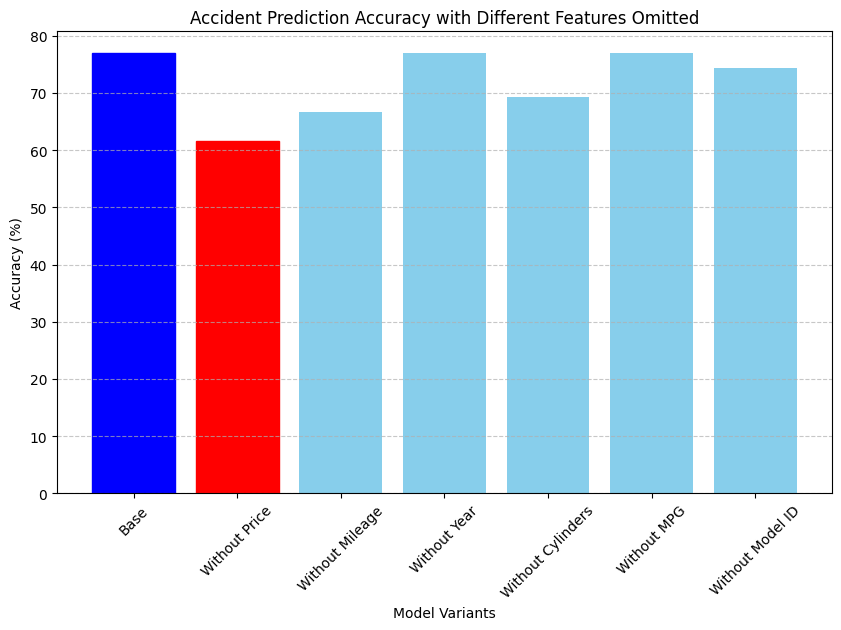

In [41]:
import matplotlib.pyplot as plt
base_acc = 0.7692307692307693*100
without_price_acc = 0.6153846153846154*100
without_mileage_acc = 0.6666666666666666*100
without_year_acc = 0.7692307692307693*100
without_cylinders_acc = 0.6923076923076923*100
without_mpg_acc= 0.7692307692307693*100
without_model_id_acc = 0.7435897435897436*100
labels = ['Base', 'Without Price', 'Without Mileage', 'Without Year', 'Without Cylinders', 'Without MPG', 'Without Model ID']
accuracies = [base_acc, without_price_acc, without_mileage_acc, without_year_acc, without_cylinders_acc, without_mpg_acc, without_model_id_acc]
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color='skyblue')
bars[0].set_color('blue')  
bars[1].set_color('red')   
plt.xlabel('Model Variants')
plt.ylabel('Accuracy (%)')
plt.title('Accident Prediction Accuracy with Different Features Omitted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


We can observe that the missing of ‘price’ feature decreases the accuracy the most and thus used cars' selling price and accident have the higher bounded relationship than other features.